# Training a dense neural network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). We use `pytorchcv` helper to load all data we have talked about in the previous unit.

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2021-07-15 03:09:28--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-07-15 03:09:28 (62.7 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

# what "pytorchcv.load_mnist()" does:
#
# import builtins  # create built-in directly callable name from import module (no need to add pytorchcv. before calling it)
# batch_size=64
# builtins.data_train = torchvision.datasets.MNIST('./data',
#     download=True,train=True,transform=ToTensor())
# builtins.data_test = torchvision.datasets.MNIST('./data',
#     download=True,train=False,transform=ToTensor())
# builtins.train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
# builtins.test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

Matplotlib is building the font cache; this may take a moment.
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
Using downloaded and verified file: ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Using downloaded and verified file: ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Fully-connected dense neural networks

A basic **neural network** in PyTorch consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Linear** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

![A graph showing how an image is broken into layers based on the pixels.](./images/dense-onelayer-network.png)

As we discussed above, the dimension of our digit images is $1\times28\times28$. Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $1\times28\times28$ to $784$.

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called **Softmax**.

In PyTorch, it is easier to use **LogSoftmax** function, which will also compute logarithms of output probabilities. To turn the output vector into the actual probabilities, we need to take **torch.exp** of the output. 

Thus, the architecture of our network can be represented by the following sequence of layers:

![An image showing the architecture of the network broken into a sequence of layers.](./images/onelayer-network-layers.png)

It can be defined in PyTorch in the following way, using `Sequential` syntax:

In [3]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),  # 784(=28*28) inputs, 10 outputs
    nn.LogSoftmax())  # log(softmax(logits)), combine log part in cross-entropy-loss with softmax layer

## Training the network

A network defined this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [4]:
print(f"Digit to be predicted: {data_train[0][1]}")
torch.exp(net(data_train[0][0]))  # take exp(outputs) to turn net's output into actual probabilities

Digit to be predicted: 5


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1051, 0.1393, 0.1047, 0.0933, 0.0845, 0.0890, 0.1047, 0.0965, 0.0981,
         0.0848]], grad_fn=<ExpBackward>)

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits. We need to give it our training data to train it on our dataset.

To train the model we will need to create **batches** of our datasets of a certain size, let's say 64. PyTorch has an object called **DataLoader** that can create batches of our data for us automatically:

In [5]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the predicted result for this minibatch. 
3. The difference between this result and expected result is calculated using a special function called the **loss function**
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called **learning rate**, and the details of optimization algorithm are defined in the **optimizer** object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called **an epoch**. 

Here is a function that performs one epoch training: 

In [6]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):  # NLLLoss: cross-entropy-loss without log
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)  # or: return first argument if both arguments are not None
    net.train()  # nn.Module default train(mode=True), but still, it is safer to specify explicitly
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)  # NLLLoss(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, dim=1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net, train_loader)

(0.005929271443684896, 0.89295)

Since this function is pretty generic we will be able to use it later in our other examples. The function takes the following parameters:
* **Neural network**
* **DataLoader**, which defines the data to train on
* **Loss Function**, which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* **Optimizer**, which defined an *optimization algorithm*. The most traditional algorithm is *stochastic gradient descent*, but we will use a more advanced version called **Adam** by default.
* **Learning rate** defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process. 

Here is what we do when training:
* Switch the network to training mode (`net.train()`)
* Go over all batches in the dataset, and for each batch do the following:
   - compute predictions made by the network on this batch (`out`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - try to minimize the loss by adjusting weights of the network (`optimizer.step()`)
   - compute the number of correctly predicted cases (**accuracy**)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:


In [7]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.0058799053192138675, 0.8928)

We train the model for several epochs observing training and validation accuracy. If training accuracy increases while validation accuracy decreases that would be an indication of **overfitting**. Meaning it will do well on your dataset but not on new data.

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [8]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # history to plot loss and accuracy
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Eposh {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res["train_loss"].append(tl)
        res["train_acc"].append(ta)
        res["val_loss"].append(vl)
        res["val_acc"].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net, train_loader, test_loader, epochs=5)

Eposh  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Eposh  1, Train acc=0.910, Val acc=0.898, Train loss=0.005, Val loss=0.006
Eposh  2, Train acc=0.913, Val acc=0.898, Train loss=0.005, Val loss=0.006
Eposh  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Eposh  4, Train acc=0.916, Val acc=0.896, Train loss=0.005, Val loss=0.006


This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called **history**). We can then visualize this data to better understand our model training.

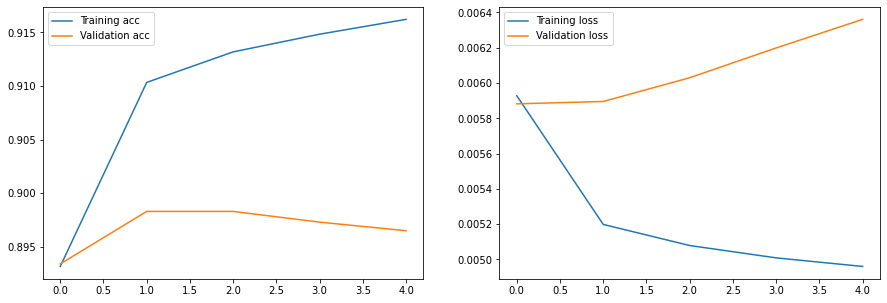

In [9]:
plt.figure(figsize=(15, 5))  # create a figure
plt.subplot(121)  # three-digits integer 121: 1=nrows, 2=ncols, and 3=index
plt.plot(hist["train_acc"], label="Training acc")
plt.plot(hist["val_acc"], label="Validation acc")
plt.legend()
plt.subplot(122)
plt.plot(hist["train_loss"], label="Training loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()

The diagram on the left shows the `training accuracy` increasing (which corresponds to the network learning to classify our training data better and better), while `validation accuracy` starts to fall. The diagram on the right show the `training loss` and `validation loss`, you can see the `training loss` decreasing (meaning its performing better) and the `validation loss` increasing (meaning its performing worse). These graphs would indicate the model is **overfitted**. 

## Visualizing network weights

Now lets visualize our weights of our neural network and see what they look like. When the network is more complex than just one layer it can be a difficult to visulize the results like this. However, in our case (classification of a digit) it happens by multiplying the initial image by a weight matrix allowing us to visualize the network weights with a bit of added logic.

Let's create a `weight_tensor` which will have a dimension of 10x784. This tensor can be obtained by calling the `net.parameters()` method. In this example, if we want to see if our number is 0 or not, we will multiply input digit by `weight_tensor[0]` and pass the result through a softmax normalization to get the answer. This results in the weight tensor elements somewhat resembling the average shape of the digit it classifies:

In [10]:
# net.state_dict()['1.weight'].size() is [10, 784] ([out_dims, in_dims])

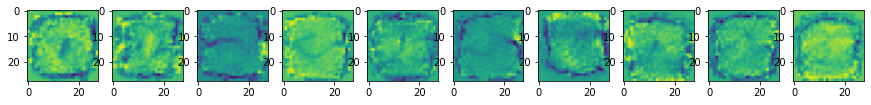

In [11]:
weight_tensor = next(net.parameters())
fig, ax = plt.subplots(1,10, figsize=(15, 4))  # Create a figure and a set of subplots
for i, x in enumerate(weight_tensor):  # digit i, x.shape=[784,]
    ax[i].imshow(x.view(28, 28).detach())  # detach(): Returns a new Tensor, detached from the current graph. The result will never require gradient.

## Takeaway 

Training a neural network in PyTorch can be programmed with a training loop. It may seem like a complicated process, but in real life we need to write it once, and we can then re-use this training code later without changing it.

We can see that a single-layer dense neural network shows relatively good performance, but we definitely want to get higher than 91% on accuracy! In the next unit, we will try to use multi-level perceptrons.